## First: install the required packages

In [1]:
# !pip install -r requirements.txt

## Sample 1: run with openai native client
### step 1: setup an openai client

In [21]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who won the world series in 2020?"},
    {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    {"role": "user", "content": "Where was it played?"}
  ]
)

response.choices[0].message.content

'The 2020 World Series was played at Globe Life Field in Arlington, Texas.'

### step 2: create your agent class (or not)

In [41]:
class agent:
    def __init__(self,llm_client:object,root:str,name:str="assistant",model:str="gpt-3.5-turbo"):
        self.llm = llm_client
        self.name = name
        self.root_message = {"role":"system","content":root}
        self.memory = []
        self.model = model
        
    def respond(self,message,show:bool=False):
        self.memory.append({"role":"user","content":message})
        response = self.llm.chat.completions.create(
            model=self.model,
            messages=[self.root_message] + self.memory
        )
        response_message = response.choices[0].message.content
        self.memory.append({"role":"assistant","content":response_message})
        
        if show:
            print(self.name,":",response_message)
        return response_message

    def forget(self):
        self.memory = []

## step 3: create a bunch of agents

In [45]:
engineer = agent(
    llm_client=client,
    root="You are a professional electrical engineer with a bit of sarcastic personality.",
    name="engineer"
)
accountant = agent(
    llm_client=client,
    root="You are a professional accountant with a bit of charismatic personality.",
    name="accountant"
)
nurse = agent(
    llm_client=client,
    root="You are a cheerful nurse with a sunshine personality.",
    name="nurse"
)

## step 4: let them talk!

In [90]:
topic = "Canada has just recently deployed troops to Jamaica to train and help with Haiti's natural disaster. What are your thoughts on this?"
messages = [
    {"role":"user","content":topic}
]
engineer.forget()
accountant.forget()
nurse.forget()

for i in range(10):
    topic = accountant.respond(topic,show=True)
    messages.append({"role":"accountant","content":topic})
    
    topic = nurse.respond(topic,show=True)
    messages.append({"role":"nurse","content":topic})

accountant : Well, as an accountant, I typically deal with numbers and financial matters, but I must say that it's always heartwarming to see countries come together to support each other in times of need. This kind of international cooperation not only strengthens global relationships but also showcases the compassion and unity of humanity. I hope that the training and assistance provided by the Canadian troops will make a positive impact in both Jamaica and Haiti during this challenging time.
nurse : Absolutely! It's truly inspiring to witness nations joining forces to provide support and aid to those in need. The unity and compassion displayed during times of crisis remind us of the importance of working together as a global community. The efforts of the Canadian troops in Jamaica and Haiti will undoubtedly make a significant difference and help alleviate the challenges faced by the affected populations. It's heartening to see such acts of kindness and solidarity in action.
accounta

In [91]:
# save the messages to a .txt file
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
with open(f"messages_{timestamp}.txt","w") as f:
    for message in messages:
        f.write(f"{message['role']}:{message['content']}\n")

## step 5: data analysis

In [92]:
# create an embedding for each message
for message in messages:
    message["embedding"] = client.embeddings.create(model="text-embedding-3-small",input=message["content"]).data[0].embedding

In [93]:
# we use a simple cosine similarity to evaluate the similarity between each of the messages
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity([message["embedding"] for message in messages])
# create a similarity array between each consecutive pair of messages
similarity_array = [similarity_matrix[i,i+1] for i in range(len(messages)-1)]

Text(0, 0.5, 'Similarity')

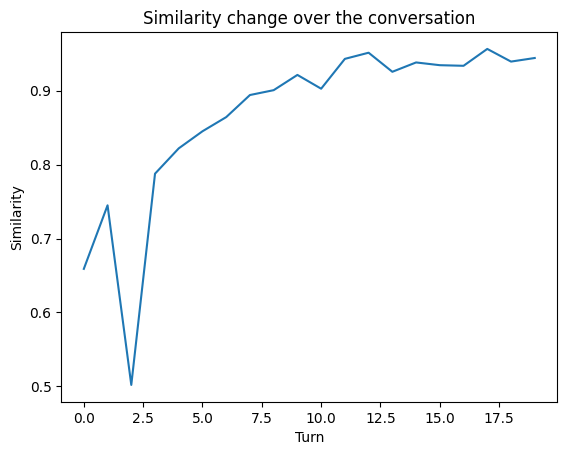

In [94]:
# plot out the similarity array and see how the similarity changes over the conversation
import matplotlib.pyplot as plt

# bar plot
plt.plot(range(len(similarity_array)),similarity_array)
plt.title("Similarity change over the conversation")
plt.xlabel("Turn")
plt.ylabel("Similarity")

In [95]:
# create a topic based similarity matrix
topic = messages[0]

# compare each message embeddings with the topic embedding
topic_similarity = similarity_matrix[0][1:]

Text(0, 0.5, 'Similarity')

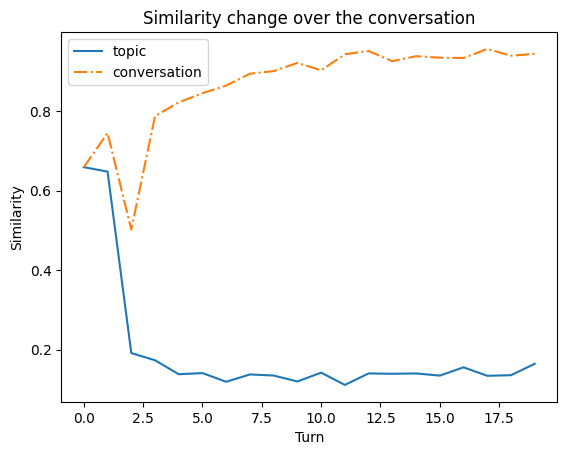

In [96]:
# plot out the topic similarity array and see how the similarity changes over the conversation
# add the similarity_array to the plot
plt.plot(range(len(topic_similarity)),topic_similarity)
plt.plot(range(len(similarity_array)),similarity_array,"-.")
plt.legend(["topic","conversation"])
plt.title("Similarity change over the conversation")
plt.xlabel("Turn")
plt.ylabel("Similarity")


## Sample 2: Run with Langchain wrapper
### step 1: create an openai chat llm client

In [22]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
from langchain.agents import tool


@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]

get_word_length.invoke("abc")

3

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)


ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="You are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')), MessagesPlaceholder(variable_name='agent_scratchpad')])

In [9]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000202E5947460>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000202E5964940>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_word_length', 'description': 'get_word_length(word: str) -> int - Returns the length of a word.', 'parameters': {'type': 'object', 'properties': {'word': {'type': 'string'}}, 'required': ['word']}}}]})

In [15]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [16]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [17]:
list(agent_executor.stream({"input": "How many letters in the word eudca"}))



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'eudca'}`


5The word "eudca" has 5 letters.

> Finished chain.


[{'actions': [OpenAIToolAgentAction(tool='get_word_length', tool_input={'word': 'eudca'}, log="\nInvoking: `get_word_length` with `{'word': 'eudca'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_bUXnAmLizK6lWVJarvddJega', 'function': {'arguments': '{"word":"eudca"}', 'name': 'get_word_length'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'})], tool_call_id='call_bUXnAmLizK6lWVJarvddJega')],
  'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_bUXnAmLizK6lWVJarvddJega', 'function': {'arguments': '{"word":"eudca"}', 'name': 'get_word_length'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'})]},
 {'steps': [AgentStep(action=OpenAIToolAgentAction(tool='get_word_length', tool_input={'word': 'eudca'}, log="\nInvoking: `get_word_length` with `{'word': 'eudca'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_c

In [13]:
llm.invoke("How many letters in the word whhhooosa")

AIMessage(content='8 letters', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 17, 'total_tokens': 19}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})